### Install Necessary Libraries ich


pip install transformers
pip install torch
pip install sklearn
pip install pandas
pip install rich


### Import Libraries:

In [51]:
import pandas as pd
import numpy as np
import langid
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
from rich.progress import track

### Load and Preprocess Dataset:

In [53]:
# Load the dataset
df = pd.read_csv('Dataset/sds.csv')

In [54]:
pd.set_option('max_colwidth', None)

In [55]:
df.head()

,Date,text,Sentiment
0,2019-05-27,È appena uscito un nuovo video! LES CRYPTOMONNAIES QUI PULVÉRISENT BITCOIN EN 2019 https://t.co/yCsQMvRnyS,Positive
1,2019-05-27,Cardano: Digitize Currencies; EOS https://t.co/1kTKqKEBlS 6500% ROI; AT&amp;T Bitcoin Bill Pay https://t.co/eQCwOXKHK0 | Cardano (ADA) 🌏📢😎🤑💵 | #FolloForFolloBack #follo4folloback #followforfollow #bitcointe #cryptocurrency,Positive
2,2019-05-27,Another Test tweet that wasn't caught in the stream ! bitcoin,Positive
3,2019-05-27,Current Crypto Prices! \n\nBTC: $8721.99 USD\nETH: $266.62 USD\nLTC: $114.03 USD\nBCH: $432.02 USD\nXLM: $0.133 USD\nDOGE: $ 0.00314 USD\nNEO: $12.04 USD\nXRP: $0.4092 USD\nCANN: $0.001482 USD\nEMC2: $0.1198 USD\nXMR: $94.65 USD\nBTG: $24.31 USD,Positive
4,2019-05-27,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NOT A Currency.\n\nhttps://t.co/FJru1ooxSM\n\nhttps://t.co/fYBX4H6r6r\n\nhttps://t.co/xZSjmZ0h3K\n\nhttps://t.co/v7GRFIQG7w\n\nhttps://t.co/Oq5hQt5hNn,Positive


In [56]:
sentiment_count = df['Sentiment'].value_counts()
print(sentiment_count)

Sentiment
Negative    9729297
Positive    8723207
Neutral         400
Name: count, dtype: int64


In [57]:
df.shape

(19344048, 3)

In [58]:
# Reduce the dataset size for manageability
negativedf = df[df['Sentiment'] == 'Negative'].sample(n=10000, random_state=42)
positivedf = df[df['Sentiment'] == 'Positive'].sample(n=10000, random_state=42)
neutraldf = df[df['Sentiment'] == 'Neutral']

In [59]:
df.shape

(19344048, 3)

(20400, 3)


<Axes: title={'center': 'Sentiment Distribution Count'}, xlabel='Sentiment'>

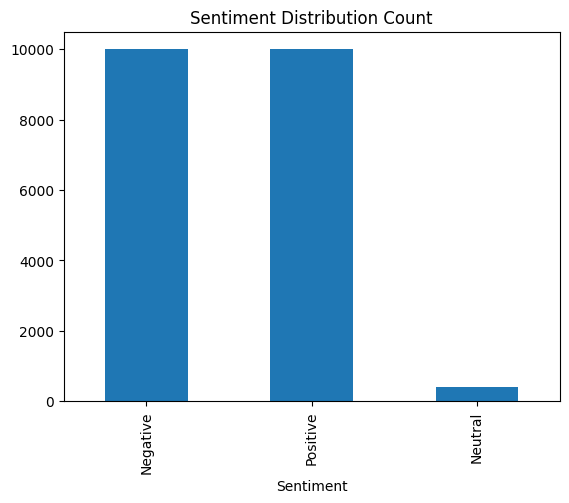

In [60]:
# Concatenate the reduced datasets
df = pd.concat([negativedf, neutraldf, positivedf])
print(df.shape)
df['Sentiment'].value_counts().plot(kind='bar',title='Sentiment Distribution Count')

In [61]:
# Detect language for each row
df['lang'] = None
for index, row in track(df.iterrows(), total=len(df)):
    text = row['text']
    if isinstance(text, str):
        language, confidence = langid.classify(text)
        df.at[index, 'lang'] = language
    else:
        df.at[index, 'lang'] = 'unknown'

Output()

In [62]:
# Filter only English tweets
df = df[df['lang'] == 'en']
print(df.shape)

# Clean dataset by removing links, hashtags, etc.
df['text'] = df['text'].str.replace(r'http\S+', '', regex=True).str.replace(r'#\w+', '', regex=True).str.replace(r'@\w+', '', regex=True).str.replace(r'\d+', '', regex=True)

# Map sentiments to integers
sentiment_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['label'] = df['Sentiment'].map(sentiment_mapping)

(14172, 4)


### Prepare Data for BERT:

In [63]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

dataset = Dataset.from_pandas(df[['text', 'label']])
tokenized_datasets = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/14172 [00:00<?, ? examples/s]

### Split the Dataset

In [64]:
train_test_split_ratio = 0.8
split = tokenized_datasets.train_test_split(test_size=1 - train_test_split_ratio)
train_dataset = split['train']
test_dataset = split['test']

### Fine-Tune the BERT Model:

In [65]:
# Load the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    acc = accuracy_score(p.label_ids, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,  # Reduced batch size
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    gradient_accumulation_steps=2,  # Use gradient accumulation
)

# Define the data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss


### Evaluate the Model:

In [ ]:
# Evaluate the model
eval_result = trainer.evaluate()
print(eval_result)


### Save the Model

In [ ]:
# Save the fine-tuned model
model.save_pretrained('./fine-tuned-bert')
tokenizer.save_pretrained('./fine-tuned-bert')
